In [1]:
import networkx as nx
from pomps.contextual_graphs import *
from pomps.policy_scope import *
from pomps.controllers import *
import pyro
import torch
import pyro.distributions as dist
from pomps.fcm import *

In [8]:
def sampler_over():
    u1 = pyro.sample("U1", dist.Uniform(-1, 1))
    u2 = pyro.sample("U2", dist.Uniform(-1, 1))
    return {"U1": u1, "U2": u2}
fcm = FunctionalCausalModel({Functor(lambda U1, U2: pyro.sample("X", dist.Normal(U1, 0.1)), 'X'),
                             Functor(lambda U1: pyro.sample("Y", dist.Normal(U1, 0.1)), 'Y'),
                             Functor(lambda Y, U2: pyro.sample("Z", dist.Normal(Y, 0.1)), 'Z')}, sampler_over)

In [22]:
with pyro.plate('samples', 100_000_000):
    samples = fcm.sample()

In [24]:
nx.draw(a, with_labels=True)

NameError: name 'a' is not defined

In [2]:
dr = (nx.DiGraph([('X1', 'X2'), ('C', 'X2'), ('X2', 'Y'), ("U1", "X2"),
                  ("U1", "Y"), ("U2", "X1"), ("U2", "C"), ("C", "Y")]))
graph = ContextualCausalGraph(dr, uc_variables='auto')
graph.uc_variables

{'U1', 'U2'}

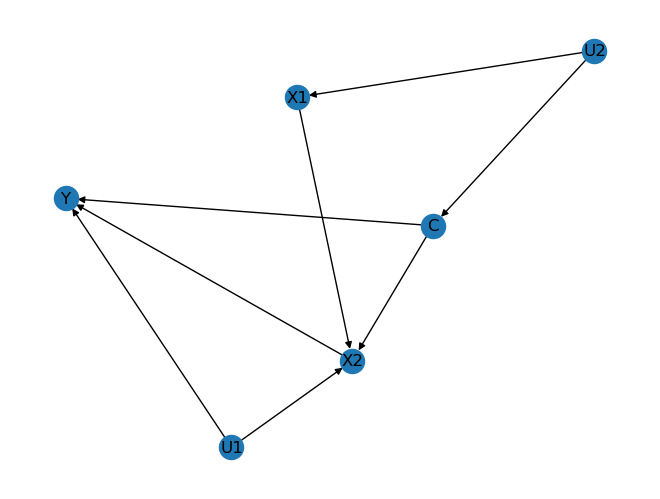

In [3]:
nx.draw(graph, with_labels=True)

In [4]:
mps = MixedPolicyScope([PolicyComponent('X1', {'C'})])
mps_graph, flag = MPSDAGController.graph_under_mps(mps, graph)
assert flag

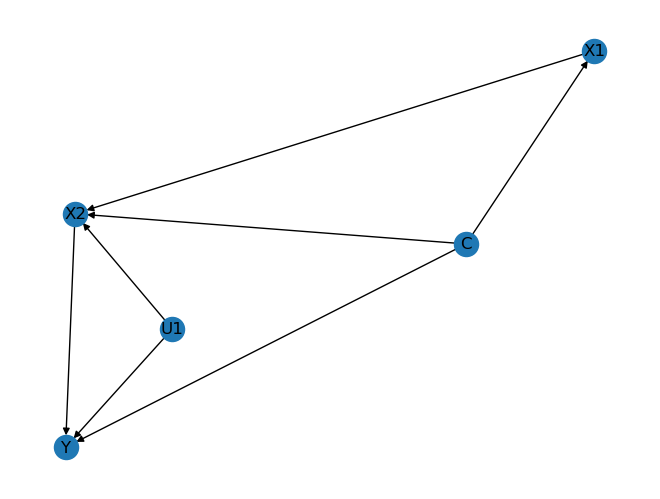

In [5]:
nx.draw(mps_graph, with_labels=True)